In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Colonic_crypt_dataset.zip (Unzipped Files)/Colonic_crypt_dataset

/content/drive/MyDrive/Colonic_crypt_dataset.zip (Unzipped Files)/Colonic_crypt_dataset


In [3]:
!ls

colon-dataset_information.csv  models  test.csv   train      train_data.csv
data			       test    test_mask  train.csv  train_mask


In [4]:
!pwd

/content/drive/MyDrive/Colonic_crypt_dataset.zip (Unzipped Files)/Colonic_crypt_dataset


In [5]:
# Importing required libraries
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import skimage.io as io
import tqdm as tqdm
import math
import time
import warnings
warnings.filterwarnings("ignore")

<tifffile.TiffFile 'HandE_B005_CL_b…_bottomleft.tiff'> shaped series axes do not match shape



 Image shape: (4536, 4704, 3)


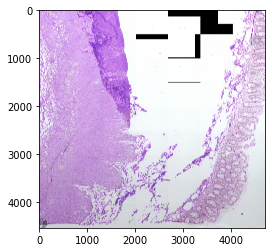


 Mask shape: (4536, 4704, 3)


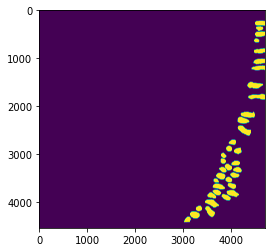

In [6]:
# Show test Image and its corresponding Mask 
image_path = "test/HandE_B005_CL_b_RGB_bottomleft.tiff"
mask_path = "test_mask/HandE_B005_CL_b_RGB_bottomleft.tiff"

image = tifffile.imread(image_path)
mask =tifffile.imread(mask_path)

print("\n Image shape:",image.shape)
plt.imshow(image)
plt.show()

print("\n Mask shape:",image.shape)
plt.imshow(mask)
plt.show()

In [7]:
# Using Train csv file 
df_train = pd.read_csv("train.csv")

In [8]:
df_train

,id,predicted
0,CL_HandE_1234_B004_bottomright,12972850 36 12977382 42 12981914 47 12986448 5...
1,CL_HandE_1234_B004_topleft,2023885 36 2028419 40 2032953 44 2037487 47 20...
2,CL_HandE_1234_B004_topright,372094 8 376628 12 381163 14 385698 16 390233 ...
3,HandE_B005_CL_b_RGB_bottomright,2247721 26 2252254 31 2256788 34 2261323 36 22...
4,HandE_B005_CL_b_RGB_topleft,366048 27 370578 43 375111 48 379646 52 384181...
5,HandE_B005_CL_b_RGB_topright,0 0


In [9]:
# Path to get train image and its corresponding mask
image_data_dir = "train/"
mask_data_dir = "train_mask/"

# Print number of train images
image_file_names = os.listdir(image_data_dir)
print("Number of train images: ",len(image_file_names)//2)

# Path where the extracted patches are stored
train_patches_directory = "data/"

Number of train images:  5


In [10]:
# Uased to extract patches of size = (512, 512) with no overlapping starting from left top as well as right bottom
def extract_valid(image_array,mask_array,patch_size=(512,512)):
    """
    This Method creates patches 
    
    args:
    df_train = dataframe containing image Ids and RLE annotations provided by CNS
    image_data_dir = Path to the train image folder
    mask_data_dir  = Path to the train mask folder
    train_patches_directory = Path to the folder where we want to save the patches
    patch_size = patch size
    
    Returns: List of np array of patches for both image ans its mask

    """
    images_list = []
    masks_list = []
    # starting from left top 
    for r in range(0,image_array.shape[0],patch_size[0]):
        for c in range(0,image_array.shape[1],patch_size[1]):
            r_patch = image_array[r:r+patch_size[0],c:c+patch_size[1]]
            r_mask = mask_array[r:r+patch_size[0],c:c+patch_size[1]]
            if r_patch.shape[:-1]!=patch_size:
                continue
                
            images_list.append(r_patch)
            masks_list.append(r_mask)
            
    # starting from right bottom
    for r in range(image_array.shape[0]-1,0,-patch_size[0]):
        for c in range(image_array.shape[1]-1,0,-patch_size[1]):
            r_patch = image_array[r-patch_size[0]:r,c-patch_size[1]:c]
            r_mask = mask_array[r-patch_size[0]:r,c-patch_size[1]:c]
            if r_patch.shape[:-1]!=patch_size:
                continue
                
            images_list.append(r_patch)
            masks_list.append(r_mask)
      
    
    return images_list,masks_list

In [11]:
def extract_patches(df_train:pd.DataFrame,image_data_dir:str,mask_data_dir:str,train_patches_directory:str,patch_size:tuple=(512,512),save_csv="train_data.csv")-> None:   

    """
    This Method creates a .csv to containing image and mask paths
    
    args:
    df_train = dataframe containing image Ids and RLE annotations
    image_data_dir  = Path to the train image folder
    mask_data_dir  = Path to the train mask folder
    train_patches_directory = Path to the folder where we want to save the patches
    patch_size = patch size
    
    Returns: None
    """
    train_data_list = []
    # Iterate through df_train
    for row in df_train.iterrows():
        # "HandE_B005_CL_b_RGB_topright" has not been provided my predictions in Train.csv file and therefore should not be considered for training
        if row[1][0]== "HandE_B005_CL_b_RGB_topright":    
            continue
        image_path  = image_data_dir+row[1][0]+".tiff"
        mask_path  = mask_data_dir+row[1][0]+".tiff"
        image_read = tifffile.imread(image_path)
        mask_read = tifffile.imread(mask_path)
        image_patch_list, mask_patch_list = extract_valid(image_read,mask_read)

        if not os.path.isdir(train_patches_directory):
            os.makedirs(train_patches_directory+"/images")
            os.makedirs(train_patches_directory+"/masks")

        for i,im in tqdm.tqdm(enumerate(image_patch_list),total=len(image_patch_list)):
            #saving images and masks
            io.imsave(train_patches_directory+"/images/"+row[1][0]+str(i)+".tiff",np.uint8(im),check_contrast=False)
            io.imsave(train_patches_directory+"/masks/"+row[1][0]+str(i)+".tiff",np.uint8(mask_patch_list[i]),check_contrast=False)
            train_data_list.append([train_patches_directory+"/images/"+row[1][0]+str(i)+".tiff",train_patches_directory+"/masks/"+row[1][0]+str(i)+".tiff",np.max((np.array(mask_patch_list[i],dtype=int)>0)*1)])
    # Save it in a .csv file for easy access
    pd.DataFrame(train_data_list,columns = ["Train_image_path","Train_mask_path","class"]).to_csv(save_csv,index=False)
                
    return None

In [12]:
extract_patches(df_train,image_data_dir,mask_data_dir,train_patches_directory)

<tifffile.TiffFile 'CL_HandE_1234_B…bottomright.tiff'> shaped series axes do not match shape
100%|██████████| 144/144 [01:50<00:00,  1.31it/s]
<tifffile.TiffFile 'CL_HandE_1234_B004_topleft.tiff'> shaped series axes do not match shape
100%|██████████| 144/144 [01:41<00:00,  1.42it/s]
<tifffile.TiffFile 'CL_HandE_1234_B004_topright.tiff'> shaped series axes do not match shape
100%|██████████| 144/144 [01:33<00:00,  1.54it/s]
<tifffile.TiffFile 'HandE_B005_CL_b_…ottomright.tiff'> shaped series axes do not match shape
100%|██████████| 144/144 [01:34<00:00,  1.53it/s]
<tifffile.TiffFile 'HandE_B005_CL_b_RGB_topleft.tiff'> shaped series axes do not match shape
100%|██████████| 144/144 [01:36<00:00,  1.49it/s]
